In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
%load_ext autoreload
%autoreload 2

In [2]:
'version:', tf.__version__ 

('version:', '2.0.0')

In [3]:
'gpu available:', tf.test.is_gpu_available()

('gpu available:', True)

# Read Data
- all datasets are datetime sorted

In [4]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '../' # Paperspace

## Amazon Fashion 

In [5]:
# file_name = 'Amazon_full' 
# file_name = 'Amazon_05_users' 
# file_name = 'Amazon_01_users'

## MovieLens 

In [6]:
data_path = 'datasets/'
# data_path = 'data/ML/'
# file_name = 'ML_full' 
# file_name = 'ML_05_users'
file_name = 'ML_01_users'

In [7]:
df = pd.read_pickle(path + data_path + file_name)
df['item_id'] = df.item.astype('category').cat.codes
df['user_id'] = df.user.astype('category').cat.codes
df.head()

,user,item,rating,datetime,item_id,user_id
18590190,120461,2501,5.0,2000-04-25 02:29:35,2372,11959
18590032,120461,252,4.0,2000-04-25 02:29:35,246,11959
18590159,120461,2069,4.0,2000-04-25 02:29:35,1946,11959
18590048,120461,440,4.0,2000-04-25 02:29:35,431,11959
18590145,120461,1959,4.0,2000-04-25 02:29:35,1836,11959


# Data Prep

## Init

In [8]:
total_items = len(df.item_id.unique())

In [10]:
res_ext = file_name[:2]
all_models = pd.read_pickle(path + 'results/' + res_ext + '/all_models')

### New Model?

In [18]:
all_models

,model_id,train_time,epochs,BATCH_SIZE,learning_rate,delta,max_seq_len,val_perc,test_perc,n_last_items,pad_value,shift_targets_by,loss,recall,val_loss,val_recall
0,1ML,38.21,2,32,0.1,0.2,30,0.1,0.1,1,27387,1,"[4.758840565921879, 4.5218276757152145]","[0.02555282, 0.040129572]","[4.606517875097631, 4.454784183967404]","[0.034687616, 0.045015093]"


In [17]:
new_model_id = str(int(all_models.model_id.max()[0]) + 1) + '_' + res_ext

In [21]:
params = {
'model_id':new_model_id,
'train_time':0,
'epochs':0,
'BATCH_SIZE':32,
'learning_rate':0.1,
'delta':0.2,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median

'val_perc':0.1,          # Percentage of users from df in val and test set
'test_perc':0.1, 
'n_last_items':1,        # Number of last (chronologically) items in val and test set

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1     
}

In [29]:
BATCH_SIZE = params['BATCH_SIZE']
learning_rate = params['learning_rate']
delta = params['delta']
max_seq_len = params['max_seq_len']

val_perc = params['val_perc']
test_perc = params['test_perc']
n_last_items = params['n_last_items']

pad_value = params['pad_value']
shift_targets_by = params['shift_targets_by'] 

## TO PICK ONE: Train Test Split

In [30]:
from Data_prep import train_val_test_split

# Train Test Val Split
total_users, total_items, train_set, val_set, test_set = \
train_val_test_split(df, BATCH_SIZE, val_perc, test_perc, n_last_items)

Total number of items: 27387
Total users: 16254
Number of train users: 16224
Number of test users: 1632
Number of validation users: 1632 

Users deleted: 30


In [31]:
from Data_prep import leave_users_out

train_set, val_set = leave_users_out(df, 1000, seed=1234)
val_set, test_set = leave_users_out(df, 500, seed=1234)

## Create Datasets
- Can make train_val_test_split and create_seq_batch_dataset one step

In [32]:
from Data_prep import create_seq_batch_dataset
    
#Train Set
train_dataset = create_seq_batch_dataset(df=train_set, 
                                         shift=shift_targets_by, 
                                         max_seq_len=max_seq_len, 
                                         pad_value=pad_value, 
                                         batch_size=BATCH_SIZE, 
                                         stats=False,
                                         drop_remainder=True)

#Val Set
val_dataset = create_seq_batch_dataset(df=val_set, 
                                       shift=shift_targets_by, 
                                       max_seq_len=max_seq_len, 
                                       pad_value=pad_value, 
                                       batch_size=BATCH_SIZE, 
                                       stats=False,
                                       drop_remainder=True)

#Test Set
test_dataset = create_seq_batch_dataset(df=test_set, 
                                       shift=shift_targets_by, 
                                       max_seq_len=max_seq_len, 
                                       pad_value=pad_value, 
                                       batch_size=BATCH_SIZE, 
                                       stats=False,
                                       drop_remainder=True)

---
# LSTM Model
Collaborative Filtering with Recurrent Neural Networks
- paper: https://arxiv.org/pdf/1608.07400.pdf
- code: https://github.com/rdevooght/sequence-based-recommendations (in Theano)

## Build Model

In [33]:
embedding_dim = 100
rnn_units = 20

In [34]:
from Models import build_LSTM_model
model = build_LSTM_model(total_items = total_items,
                         embedding_dim = embedding_dim,
                         mask_value = pad_value,
                         rnn_units = rnn_units,
                         batch_size = BATCH_SIZE)

## Add Custom Metric=Recall and Loss=Diversity Bias Loss

In [35]:
from Evaluation import recall_metric, diversity_bias_loss, create_diversity_bias

In [36]:
diversity_bias = create_diversity_bias(train_set, total_items, delta)

In [37]:
optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate)
loss=diversity_bias_loss(db=diversity_bias, total_items=total_items)
metrics=[recall_metric(total_items=total_items)]

model.compile(optimizer=optimizer,
              loss=loss, 
              metrics=metrics)

## Summmary

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 100)           2738800   
_________________________________________________________________
masking (Masking)            (32, None, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (32, None, 20)            9680      
_________________________________________________________________
dense (Dense)                (32, None, 27387)         575127    
Total params: 3,323,607
Trainable params: 3,323,607
Non-trainable params: 0
_________________________________________________________________


---
# Train Model

## Configure Callbacks

In [377]:
ext = '_' + file_name[:2] #ML or Am
directory = './ckpts' 
directory = '../ckpts/ckpts'

# Directory where the checkpoints will be saved
checkpoint_dir = directory + '_' + str(params['model_id'])

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [47]:
from Helpers import TimingCallback

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_prefix,    
                                                         monitor = 'val_recall',    
                                                         mode = 'max',    
                                                         save_best_only = True,
                                                         save_weights_only = True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'recall',
                                                           min_delta = 0.0001,
                                                           mode = 'max',
                                                           patience = 15)
    

timing_callback = TimingCallback()

## Fit Model

In [254]:
epochs = 2
print('#Batches:', tf.data.experimental.cardinality(train_dataset).numpy())
print('Batch size:', BATCH_SIZE)

#Batches: 476
Batch size: 32


In [255]:
print('Fitting LSTM with max sequence length:', str(max_seq_len))
history = model.fit(x = train_dataset, 
                    validation_data=val_dataset, 
                    epochs=epochs,
#                         batch_size=BATCH_SIZE,
#                         class_weight=class_weights,
#                         sample_weight=np.vstack(train_sample_weights),
                    callbacks=[checkpoint_callback, early_stopping_callback, timing_callback])

Fitting LSTM with max sequence length: 30
Epoch 1/2
476/476 [==============================] - 22s 45ms/step - loss: 4.4115 - recall: 0.0490 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
476/476 [==============================] - 21s 44ms/step - loss: 4.3450 - recall: 0.0574 - val_loss: 4.3201 - val_recall: 0.0605


# TODO

In [405]:
def add_to_existing_model(model_dict, final_results):
    print('Adding to existing DataFrame')
    print(model_dict)
    final_results['epochs'] += model_dict['epochs']
    final_results['train_time'] += model_dict['train_time']
    train_values = ['recall', 'val_recall', 'loss', 'val_loss']
    for train_value in train_values:
        final_results[train_value].extend(model_dict[train_value])
    
    final_results_df = pd.DataFrame(final_results)
    
    return final_results_df

In [429]:
def store_LSTM_model(path, params, history, train_time):
    final_results = {**params, **history.history, 'train_time':train_time, 'epochs':len(history.history['loss'])}
    
    if os.path.exists(path):
        all_models = pd.read_pickle(path)
#         if len(all_models) == 1 and final_results['model_id'] in all_models['model_id']:
#             all_models.update(add_to_existing_model(all_models.to_dict(), final_results))
            
        if final_results['model_id'] in set(all_models['model_id']):
            model_index = 0
            if len(all_models) > 1:
                model_index = all_models[all_models['model_id']==final_results['model_id']].index
            all_models.update(add_to_existing_model(all_models.iloc[model_index].to_dict(), final_results))
            
        else:##
            all_models = all_models.append(final_results, ignore_index=True)
    else:##   
        all_models = pd.DataFrame(columns=final_results.keys())
        all_models = all_models.append(final_results, ignore_index=True)
    
    return all_models

In [442]:
all_models[all_models['model_id']==final_results['model_id']].index

<function str.index>

In [452]:
all_models[all_models['model_id'] == '1_ML']

85.51350998878479

In [459]:
all_models.iloc[0]

model_id                                              2_ML
train_time                                         85.5135
epochs                                                   2
BATCH_SIZE                                              32
learning_rate                                          0.1
delta                                                  0.2
max_seq_len                                             30
val_perc                                               0.1
test_perc                                              0.1
n_last_items                                             1
pad_value                                            27387
shift_targets_by                                         1
loss                [4.411530450612557, 4.344958093987794]
recall                           [0.048959255, 0.05737415]
val_loss            [4.373318672180176, 4.320149163889691]
val_recall                       [0.053253733, 0.06053967]
Name: 0, dtype: object

In [454]:
params

{'model_id': '2_ML',
 'train_time': 0,
 'epochs': 0,
 'BATCH_SIZE': 32,
 'learning_rate': 0.1,
 'delta': 0.2,
 'max_seq_len': 30,
 'val_perc': 0.1,
 'test_perc': 0.1,
 'n_last_items': 1,
 'pad_value': 27387,
 'shift_targets_by': 1}

In [458]:
all_models = store_LSTM_model(store_path, params, history, train_time)
# all_models.to_pickle(store_path)
all_models

Int64Index([0], dtype='int64')
Adding to existing DataFrame
{'model_id': {0: '2_ML'}, 'train_time': {0: 85.51350998878479}, 'epochs': {0: 2}, 'BATCH_SIZE': {0: 32}, 'learning_rate': {0: 0.1}, 'delta': {0: 0.2}, 'max_seq_len': {0: 30}, 'val_perc': {0: 0.1}, 'test_perc': {0: 0.1}, 'n_last_items': {0: 1}, 'pad_value': {0: 27387}, 'shift_targets_by': {0: 1}, 'loss': {0: [4.411530450612557, 4.344958093987794]}, 'recall': {0: [0.048959255, 0.05737415]}, 'val_loss': {0: [4.373318672180176, 4.320149163889691]}, 'val_recall': {0: [0.053253733, 0.06053967]}}


TypeError: unsupported operand type(s) for +=: 'int' and 'dict'

In [306]:
all_models

model_id                                              2_ML
train_time                                         42.8197
epochs                                                   2
BATCH_SIZE                                              32
learning_rate                                          0.1
delta                                                  0.2
max_seq_len                                             30
val_perc                                               0.1
test_perc                                              0.1
n_last_items                                             1
pad_value                                            27387
shift_targets_by                                         1
loss                [4.765899322613948, 4.524667009586046]
recall                           [0.025187327, 0.03997531]
val_loss            [4.610616824491237, 4.456750662346196]
val_recall                      [0.034631453, 0.045065023]
Name: 0, dtype: object

In [307]:
from Helpers import store_LSTM_model
add_new_LSTM_results(path, params, history, np.sum(timing_callback.logs))
total_train_time = round(params['train_time'] + np.sum(timing_callback.logs),2)
total_epochs = params['epochs'] + epochs
results = pd.DataFrame(history.history)
final_results = {**params, **history.history, 'train_time':total_train_time, 'epochs':total_epochs}

ImportError: cannot import name 'store_LSTM_model'

In [132]:
print(file_name, res_ext)

ML_01_users ML


In [136]:
all_models = pd.DataFrame(columns=final_results.keys())

In [139]:
all_models = pd.read_pickle(path + 'results/' + res_ext + '/all_models')
# all_models = all_models.append(final_results, ignore_index=True)
all_models

,model_id,train_time,epochs,BATCH_SIZE,learning_rate,delta,max_seq_len,val_perc,test_perc,n_last_items,pad_value,shift_targets_by,loss,recall,val_loss,val_recall
0,1ML,38.21,2,32,0.1,0.2,30,0.1,0.1,1,27387,1,"[4.758840565921879, 4.5218276757152145]","[0.02555282, 0.040129572]","[4.606517875097631, 4.454784183967404]","[0.034687616, 0.045015093]"


In [138]:
all_models.to_pickle(path + 'results/' + res_ext + '/all_models')

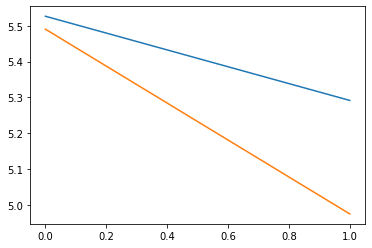

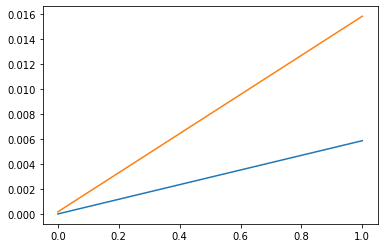

In [59]:
plt.plot(results['loss'])
plt.plot(results['val_loss'])
plt.show()
plt.plot(results['recall'])
plt.plot(results['val_recall'])
plt.show()

---
## Continue training from checkpoint

In [396]:
tf.train.latest_checkpoint(checkpoint_dir)
model = build_model(total_items, embedding_dim, pad_value, rnn_units, batch_size=BATCH_SIZE)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.compile(optimizer=tf.keras.optimizers.Adagrad(lr=learning_rate), 
              loss=db_loss(db=db), 
              metrics=[recall])

In [397]:
initial_epoch = 800
total_epochs = 900

In [398]:
history = model.fit(dataset, 
                    validation_data=val_dataset, 
                    epochs=total_epochs, 
                    callbacks=[checkpoint_callback, early_stopping_callback], 
                    initial_epoch=initial_epoch)
#                     class_weight=class_weights)

Epoch 801/900
476/476 [==============================] - 26s 55ms/step - loss: 3.6794 - recall: 0.2695 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 802/900
476/476 [==============================] - 19s 40ms/step - loss: 3.6791 - recall: 0.2696 - val_loss: 3.6796 - val_recall: 0.2696
Epoch 803/900
476/476 [==============================] - 19s 40ms/step - loss: 3.6787 - recall: 0.2696 - val_loss: 3.6792 - val_recall: 0.2697
Epoch 804/900
476/476 [==============================] - 19s 40ms/step - loss: 3.6783 - recall: 0.2697 - val_loss: 3.6788 - val_recall: 0.2697
Epoch 805/900
476/476 [==============================] - 19s 40ms/step - loss: 3.6779 - recall: 0.2697 - val_loss: 3.6784 - val_recall: 0.2697
Epoch 806/900
476/476 [==============================] - 19s 40ms/step - loss: 3.6774 - recall: 0.2698 - val_loss: 3.6779 - val_recall: 0.2698
Epoch 807/900
476/476 [==============================] - 19s 40ms/step - loss: 3.6770 - recall: 0.2698 - val_loss: 3.6775 - val_recall

---
# Predict Sequences

## Restore Latest Checkpoints
- TODO: include partial when loading weights

In [28]:
model = build_model(total_items, embedding_dim, pad_value, rnn_units, batch_size=1, return_sequences=False)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 100)            2738800   
_________________________________________________________________
masking_2 (Masking)          (1, None, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 20)                   9680      
_________________________________________________________________
dense_2 (Dense)              (1, 27387)                575127    
Total params: 3,323,607
Trainable params: 3,323,607
Non-trainable params: 0
_________________________________________________________________


In [30]:
tf.train.latest_checkpoint(checkpoint_dir)

'../ckpts/ckpts_30ML_01_users_lr0.1_batch32_mask/ckpt'

In [40]:
def get_predictions(model, train_set, test_set, rank_at):
    """
    Uses a Keras model with batch size set to 1 to predict the rest of the sequences from the train_set per user.
    Finally creates predictions_df where each row represents user, a list pred_items_ranked and a list containing true_ids
    from the test_set
    :param model: Keras RNN model with batch size set to 1
    :param train_set: pandas df containing user_id, item_id sorted on datetime per user
    :param test_set: pandas df containing: user_id, last item_id(s) per user
    :param rank_at: maximum of top ranked items per user
    :param temp: temperature, 1 means no deviation from model prediction
    :return: pandas df where each row represents a user, the columns represent: pred_items_ranked at rank_at,
             true_id extracted from test_set
    """
    test_user_sequences = train_set[train_set.user_id.isin(test_set.user_id.unique())].groupby('user_id')['item_id'].apply(list)
    user_items = np.array(test_set.groupby('user_id')['item_id'].apply(list))
    users = test_user_sequences.index 
    all_predictions = []
    all_true_items = []

    for true_items, user_sequence in zip(user_items, test_user_sequences):
        predictions = []
        all_true_items.append(list(np.array(true_items)))
        for i in range(rank_at):
            pred_item_id = model.predict_classes(np.array([user_sequence,]), batch_size=1)
            user_sequence.append(pred_item_id)
            predictions.append(pred_item_id)

        all_predictions.append(predictions)

    predictions_df = pd.DataFrame(list(zip(users, all_predictions, all_true_items)),
                              columns=['user', 'pred_items_ranked', 'true_id'])


    return predictions_df

In [ ]:
rank_at = 20
preds_df = get_predictions(model, train_set, test_set, rank_at)

In [32]:
test_set_u_i = test_set.groupby('user_id')['item_id'].apply(list)
test_X = []
test_y = []
all_predictions = []
for user_items in test_set_u_i:
    test_X.append(user_items[-200:-1])
    test_y.append(user_items[-1:])

for i, seq in enumerate(test_X): 
    seq = seq.copy()
    predictions = []
    for i in range(20):
        pred_item_id = model.predict_classes(np.array([seq,]), batch_size=1)[0]
        seq.append(pred_item_id)
        predictions.append(pred_item_id)
    all_predictions.append(predictions)
    
predictions_df = pd.DataFrame(list(zip(test_set.user_id.unique(), all_predictions, test_y)),
                              columns=['user', 'pred_items_ranked', 'true_id'])

In [ ]:
# for p in predictions_df['pred_items_ranked']:
#     for i in p:
#         if i != 348:
#             print(i)

In [33]:
train_set.groupby('item_id')['user_id'].count().sort_values(ascending=False)[:20]

item_id
311     7762
348     7684
289     7468
581     6946
2441    6855
254     6457
471     6022
518     5733
107     5521
2823    5510
577     5400
1148    5391
0       5363
4805    5274
49      5177
1150    5133
1161    5127
2724    5109
828     4936
5734    4877
Name: user_id, dtype: int64

In [34]:
predictions_df

,user,pred_items_ranked,true_id
0,9430,"[289, 289, 581, 581, 581, 581, 581, 581, 311, ...",[11411]
1,15350,"[348, 348, 348, 289, 311, 289, 311, 311, 145, ...",[13707]
2,9516,"[10968, 10968, 10968, 10968, 10968, 10968, 109...",[17257]
3,7237,"[348, 348, 348, 348, 348, 348, 348, 348, 348, ...",[348]
4,13653,"[254, 254, 254, 254, 254, 254, 254, 254, 254, ...",[532]
...,...,...,...
495,3602,"[753, 753, 753, 630, 630, 630, 630, 630, 630, ...",[1131]
496,9515,"[761, 761, 761, 761, 761, 761, 761, 761, 761, ...",[336]
497,11961,"[828, 828, 828, 254, 254, 254, 828, 254, 254, ...",[1800]
498,14898,"[289, 289, 581, 581, 581, 581, 581, 581, 581, ...",[5098]


## Create Predictions
- **TODO: Can keep batches of 64 for evaluation => faster**

Using train_set sequences to predict test_set / val_set item(s)

In [373]:
from Evaluation import get_predictions

In [374]:
file_name

'ML_01_users'

### Val Set Predictions

In [33]:
rank_at = 20
preds_val = get_predictions(model, train_set, val_set, rank_at)
preds_val.to_pickle('../results/preds_val_CFRNN_vsl_100_' + file_name + '_lr' + str(learning_rate))

### Fixed

In [33]:
rank_at = 20
preds_val = get_predictions(model, train_set, val_set, rank_at)
preds_val.to_pickle('../results/preds_val_CFRNN_fixed_100_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

### Test Set Predictions

In [34]:
rank_at = 20
preds_test = get_predictions(model, train_set, test_set, rank_at)
preds_test.to_pickle('../results/preds_test_CFRNN_vsl_100_' + file_name + '_lr' + str(learning_rate))

### Fixed

In [34]:
rank_at = 20
preds_test = get_predictions(model, train_set, test_set, rank_at)
preds_test.to_pickle('../results/preds_test_CFRNN_fixed_100_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

#### Read Predictions

In [55]:
# predictions = pd.read_pickle('CFRNN_res_200_ML_01_users')

---
# Evaluate

In [ ]:
preds_df

In [ ]:
from Evaluation import get_metrics

In [ ]:
metrics_test_set_vsl = get_metrics(preds_df, 5, 20)
metrics_test_set_vsl

### Val Set Metrics

In [36]:
metrics_val_set_vsl = get_metrics(preds_val, 5, 20)
metrics_val_set_vsl

Obtaining metrics time: 1.12


,rank_at,hitcounts,recall,precision
0,1,1,0.000601,0.000601
1,5,8,0.004808,0.000962
2,10,15,0.009014,0.000901
3,15,21,0.012620,0.000841
4,20,27,0.016226,0.000811


In [37]:
metrics_val_set_vsl.to_pickle('../results/metrics_val_CFRNN_fixed_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

In [37]:
metrics_val_set_vsl.to_pickle('../results/metrics_val_CFRNN_vsl_' + file_name + '_lr' + str(learning_rate))

### Test Set Metrics

In [38]:
metrics_test_set_vsl = get_metrics(preds_test, 5, 20)
metrics_test_set_vsl

Obtaining metrics time: 1.13


,rank_at,hitcounts,recall,precision
0,1,1,0.000601,0.000601
1,5,4,0.002404,0.000481
2,10,8,0.004808,0.000481
3,15,12,0.007212,0.000481
4,20,19,0.011418,0.000571


In [39]:
metrics_test_set_vsl.to_pickle('../results/metrics_test_CFRNN_fixed_' + str(max_seq_len) + '_' + file_name + '_lr' + str(learning_rate))

In [39]:
metrics_test_set_vsl.to_pickle('../results/metrics_test_CFRNN_vsl_' + file_name + '_lr' + str(learning_rate))

# Appendix

In [ ]:
# oh_input = tf.keras.backend.one_hot(padded, n_items)
# e = tf.keras.layers.Embedding(n_items, 100, input_length=max_l)

In [ ]:
# One hot encoded input
# sequences_data_x = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_x, n_items)) 
# sequences_data_y = tf.data.Dataset.from_tensor_slices(tf.keras.backend.one_hot(padded_sequences_y, n_items)) 

In [ ]:
# max_seq_len = 30
# min_seq_len = 10
# shift_targets_by = 1

# from Data_prep import get_x_y_sequences, min_padding
# vsl = True # Set for training later

# # Train Set
# user_sequences_x, user_sequences_y, user_order = get_x_y_sequences(train_set, shift_targets_by)
# padded_sequences_x = min_padding(user_sequences_x, BATCH_SIZE, min_seq_len, max_seq_len)
# padded_sequences_y = min_padding(user_sequences_y, BATCH_SIZE, min_seq_len, max_seq_len)

# # Val Set 
# user_sequences_val_x, user_sequences_val_y, user_order = get_x_y_sequences(val_set, shift_targets_by, stats=False)
# padded_sequences_val_x = min_padding(user_sequences_val_x, BATCH_SIZE, min_seq_len, max_seq_len)
# padded_sequences_val_y = min_padding(user_sequences_val_y, BATCH_SIZE, min_seq_len, max_seq_len)